In [58]:
import os 
import pandas as pd
import numpy as np
from src.utils import fileio
import matplotlib.pyplot as plt

import seaborn as sns

colorblind_palette = sns.color_palette("colorblind", n_colors=5)
colors = {
    'CTRL': colorblind_palette[0],
    'ISO': colorblind_palette[1],
    'L-DA + OA': colorblind_palette[2],
    'L-DA': colorblind_palette[3],
    'OA': colorblind_palette[4],
}

normalized_columns = {
    'vel': 'Velocity',
    'ang_vel': 'Angular velocity',
    'min_wing_ang': 'Minimum wing angle',
    'max_wing_ang': 'Maximum wing angle',
    'mean_wing_length': 'Mean wing length',
    'dist_to_wall': 'Distance to wall',
    'dist_from_center': 'Distance from center',
    'dist_to_closest': 'Distance to closest Fly',
    'mean_dist_to_all': 'Mean distance to all flies',
    'Mean degree weight=count': 'Strenght (Count)',
    'Mean degree weight=duration(seconds)': 'Strenght (Duration)',
    'Degree heterogeneity (count)': 'Degree Heterogeneity (Count)',
    'Degree heterogeneity (total duration (seconds))': 'Degree Heterogeneity (Duration)',
    'Degree aassortativity (count)': 'Degree Assortativity (Count)',
    'Degree aassortativity (total duration (seconds))': 'Degree Assortativity (Duration)',
    'Average clustering coefficient weight=count': 'Clustering Coefficient (Count)',
    'Average clustering coefficient weight=duration(seconds)': 'Clustering Coefficient (Duration)',
    'Average betweenness centrality weight=count': 'Betweenness Centrality (Count)',
    'Average betweenness centrality weight=duration(seconds)': 'Betweenness Centrality (Duration)',
    'Average closseness centrality weight=count': 'Closeness Centrality (Count)',
    'Average closseness centrality weight=duration(seconds)': 'Closeness Centrality (Duration)'
}

desired_order = [
    'Velocity',
    'Angular velocity',
    'Minimum wing angle',
    'Maximum wing angle',
    'Mean wing length',
    'Distance to wall',
    'Distance from center',
    'Distance to closest Fly',
    'Mean distance to all flies',
    'Strenght (Count)',
    'Strenght (Duration)',
    'Degree Heterogeneity (Count)',
    'Degree Heterogeneity (Duration)',
    'Degree Assortativity (Count)',
    'Degree Assortativity (Duration)',
    'Clustering Coefficient (Count)',
    'Clustering Coefficient (Duration)',
    'Betweenness Centrality (Count)',
    'Betweenness Centrality (Duration)',
    'Closeness Centrality (Count)',
    'Closeness Centrality (Duration)'
]

c = ['Mean degree weight=count', 'Mean degree weight=duration(seconds)',
 'Degree heterogeneity (count)', 'Degree heterogeneity (total duration (seconds))',
 'Degree aassortativity (count)', 'Degree aassortativity (total duration (seconds))',
 'Average clustering coefficient weight=count', 'Average clustering coefficient weight=duration(seconds)',
 'Average betweenness centrality weight=count', 'Average betweenness centrality weight=duration(seconds)',
 'Average closseness centrality weight=count', 'Average closseness centrality weight=duration(seconds)']


def get_z_scores(df, selected_treatments):
    filtered_df = df.loc[df.index.get_level_values('Treatment').isin(selected_treatments)]

    z_scores = (filtered_df - filtered_df.mean()) / filtered_df.std()
    z_scores = z_scores.groupby(level=['Treatment']).agg(['mean', 'sem'])
    z_scores = z_scores.T
    
    return z_scores
    
    
TREATMENTS = ['CS_10D', 'CsCh', 'Cs_5DIZ', 'LDA_5DIZ', 'OCT_5DIZ', 'LDA_OCT_5DIZ']
cols = ['pos x', 'pos y', 'ori', 'vel', 'ang_vel', 'min_wing_ang', 'max_wing_ang', 'mean_wing_length']

path_trackings = '/srv/milky/drosophila-datasets/drosophila-isolation/data/processed/0_0_preproc_data'
path_distances = '/srv/milky/drosophila-datasets/drosophila-isolation/data/processed/0_1_1_distances_matrix'

trackings = fileio.load_multiple_folders(path_trackings)
arena_center = (30.5, 30.5)
radius = 30.5

res_treatment = pd.DataFrame()
groups_dataframes = []

for t in TREATMENTS:
    group_trackings = fileio.load_multiple_folders(trackings[t])
    treatment_distances = fileio.load_files_from_folder(os.path.join(path_distances, t), '.csv')
    
    for group_name, group_path in group_trackings.items():
        distances = pd.read_csv(treatment_distances[f'{group_name}.csv'], index_col=0)
        flies = fileio.load_files_from_folder(group_path, '.csv')
        
        res_group = pd.DataFrame()       
        for fly_name, fly_path in flies.items():
            df = pd.read_csv(fly_path, usecols=cols)
            pos_x = df['pos x'].to_numpy()
            pos_y = df['pos y'].to_numpy()
            df['dist_to_wall'] = 30.5 - np.sqrt((pos_x - radius)**2 + (pos_y - radius)**2)
            df['dist_from_center'] = np.sqrt((pos_x - radius)**2 + (pos_y - radius)**2)
            
            df = df[['vel', 'ang_vel', 'min_wing_ang', 'max_wing_ang', 'mean_wing_length', 'dist_to_wall', 'dist_from_center']]
            
            fly_distances = distances[distances.columns[distances.columns.str.startswith(fly_name)]]
            df['dist_to_closest'] = fly_distances.min(axis=1)
            df['mean_dist_to_all'] = fly_distances.mean(axis=1) 
            df = df.mean()
            
            df['Fly'] = fly_name.replace('.csv','')
            df['Group'] = group_name
            df['Treatment'] = t
            
            res_group = pd.concat([res_group, df], axis=1)
        
        res_group = res_group.T
        res_group.set_index("Fly", append=True, inplace=True)
        res_group.set_index("Group", append=True, inplace=True)
        res_group.set_index("Treatment", append=True, inplace=True)
        res_group = res_group.reorder_levels([None, "Treatment", "Group", "Fly"])
        
        groups_dataframes.append(res_group)


res = pd.concat(groups_dataframes)
grouped_stats = res.groupby(level=['Treatment']).agg(['mean', 'std'])
grouped_stats.to_excel('./res/stats.xlsx')


path = "/srv/milky/drosophila-datasets/drosophila-isolation/data/results/global_measures"
measures = fileio.load_files_from_folder(path, '.csv')

global_measures = pd.DataFrame()
global_measures_z_scores = pd.DataFrame()

for t in TREATMENTS:
    df = pd.read_csv(measures[f"{t}.csv"], index_col=0)
    df = df[c]
    df['Treatment'] = t
    global_measures = pd.concat([global_measures, df])

    df_pseudo = pd.read_csv(measures[f"pseudo_{t}.csv"], index_col=0)
    df_pseudo = df_pseudo[c]

    pseudo_mean = df_pseudo.mean()
    pseudo_std = df_pseudo.std()
    df_z_scores = (df - pseudo_mean) / pseudo_std
    df_z_scores['Treatment'] = t
    global_measures_z_scores = pd.concat([global_measures_z_scores, df_z_scores])

global_measures.set_index("Treatment", append=True, inplace=True)
global_measures.index = global_measures.index.set_names(['Group', 'Treatment'])
global_measures_all = global_measures
global_measures = global_measures.reorder_levels(["Treatment", "Group"])
global_measures = global_measures.groupby(level=['Treatment']).agg(['mean', 'std'])
global_measures.to_excel('./res/network_stats.xlsx')

global_measures_z_scores.set_index("Treatment", append=True, inplace=True)
global_measures_z_scores.index = global_measures_z_scores.index.set_names(['Group', 'Treatment'])
glob_z_s = global_measures_z_scores
global_measures_z_scores = global_measures_z_scores.reorder_levels(["Treatment", "Group"])
global_measures_z_scores = global_measures_z_scores.groupby(level=['Treatment']).agg(['mean', 'std'])
global_measures_z_scores.to_excel('./res/network_stats.xlsx')

global_measures_t = global_measures.T
grouped_stats_t = grouped_stats.T
final = pd.concat([grouped_stats_t, global_measures_t])

res_group = res.groupby(level=['Treatment', 'Group']).agg('mean')
merged_df = res_group.join(global_measures_all, how='inner')
merged_df.rename(columns=normalized_columns, inplace=True)

rename_dict = {
    'CS_10D': 'CTRL',
    'Cs_5DIZ': 'ISO',
    'LDA_OCT_5DIZ': 'L-DA + OA',
    'LDA_5DIZ': 'L-DA',
    'OCT_5DIZ': 'OA',
}

merged_df = merged_df.rename(index=rename_dict, level='Treatment')


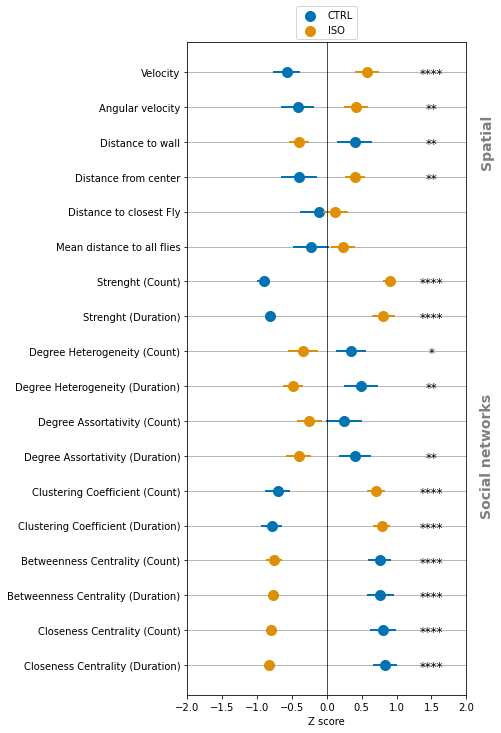

In [115]:
# selected_treatments = ['CS_10D', 'Cs_5DIZ', 'OCT_5DIZ']
# values_to_plot = get_z_scores(merged_df, selected_treatments)
# plot_means_with_error_bars(values_to_plot, selected_treatments, colors, error_type='sem', xlim=[-2, 2], title="")

# selected_treatments = ['CS_10D', 'Cs_5DIZ', 'LDA_OCT_5DIZ']
# values_to_plot = get_z_scores(merged_df, selected_treatments)
# plot_means_with_error_bars(values_to_plot, selected_treatments, colors, error_type='sem', xlim=[-2, 2], title="")

# selected_treatments = ['CS_10D', 'Cs_5DIZ']
# plot_means_with_error_bars(global_measures_z_scores.T, selected_treatments, colors, error_type='std', xlim=[-10, 21], title="No social cues networks used for null")

# selected_treatments = ['LDA_5DIZ', 'OCT_5DIZ', 'LDA_OCT_5DIZ']
# plot_means_with_error_bars(global_measures_z_scores.T, selected_treatments, colors, error_type='std', xlim=[-10, 21], title="No social cues networks used for null")

# selected_treatments = ['CS_10D', 'Cs_5DIZ', 'LDA_OCT_5DIZ']
# plot_means_with_error_bars(global_measures_z_scores.T, selected_treatments, colors, error_type='std', xlim=[-10, 21], title="No social cues networks used for null")


def plot_means_with_error_bars(global_measures_t, selected_treatments, colors, error_type, xlim, title):
    # global_measures_t = global_measures_t.drop('Minimum wing angle', axis=1)
    # global_measures_t = global_measures_t.drop('Maximum wing angle', axis=1)
    # global_measures_t = global_measures_t.drop('Mean wing length', axis=1)
    sig_df = pd.read_csv('./res/ctrl_vs_iso.csv', index_col=0)
    sig_map = dict(zip(sig_df.iloc[:, 0], sig_df['significance']))

    sample = global_measures_t[selected_treatments]
    sample.index = sample.index.set_names(['measure', 'mean_std'])
    
    measures = [
        'Velocity',
        'Angular velocity',
        'Distance to wall',
        'Distance from center',
        'Distance to closest Fly',
        'Mean distance to all flies',
        'Strenght (Count)',
        'Strenght (Duration)',
        'Degree Heterogeneity (Count)',
        'Degree Heterogeneity (Duration)',
        'Degree Assortativity (Count)',
        'Degree Assortativity (Duration)',
        'Clustering Coefficient (Count)',
        'Clustering Coefficient (Duration)',
        'Betweenness Centrality (Count)',
        'Betweenness Centrality (Duration)',
        'Closeness Centrality (Count)',
        'Closeness Centrality (Duration)'
    ]
    measures = measures[::-1]
    measurements, sds = [[] for _ in selected_treatments], [[] for _ in selected_treatments]
    
    for i, measure in enumerate(measures):
        data = sample.xs(measure, level='measure')
        for j, treatment in enumerate(selected_treatments):
            measurements[j].append(data[treatment]['mean'])
            sds[j].append(data[treatment][error_type])

    _, ax = plt.subplots(figsize=(5, 12))
    y_positions = list(range(len(measures)))  # numeric y positions
    
    for i, treatment in enumerate(selected_treatments):
        ax.errorbar(measurements[i], y_positions, xerr=sds[i], fmt='o', color=colors[treatment],
                    ecolor=colors[treatment], elinewidth=2, capsize=0)
        ax.scatter(measurements[i], y_positions, color=colors[treatment], label=treatment, s=100)
    
    # Add significance stars as text annotations
    for y_idx, measure in enumerate(measures):
        sig = sig_map.get(measure, '')
        if sig != 'Ns' and sig != '':
            ax.text(xlim[1] - 0.5 , y_idx - 0.05, sig, fontsize=12, va='center', ha='center', color='black')

    ax.text(2.3, 15, 'Spatial', rotation=90, fontsize=14, fontweight='bold',
        va='center', ha='center', color='gray')

    ax.text(2.3, 6, 'Social networks', rotation=90, fontsize=14, fontweight='bold',
            va='center', ha='center', color='gray')

    ax.set_yticks(y_positions)
    ax.set_yticklabels(measures)
    ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.7)
    ax.set_xlabel('Z score')
    ax.legend(loc='center left', bbox_to_anchor=(0.37, 1.03))
    plt.grid(axis='y', linestyle='-', color='gray', alpha=0.7)
    plt.xlim(xlim[0], xlim[1])  # extend x-axis to make room for stars
    plt.title(title)

    # plt.tight_layout()
    plt.show()

selected_treatments = ['CTRL', 'ISO']
values_to_plot = get_z_scores(merged_df, selected_treatments)
plot_means_with_error_bars(values_to_plot, selected_treatments, colors, error_type='sem', xlim=[-2, 2], title="")

In [54]:
merged_df.columns



Index(['Velocity', 'Angular velocity', 'Distance to wall',
       'Distance from center', 'Distance to closest Fly',
       'Mean distance to all flies', 'Strenght (Count)', 'Strenght (Duration)',
       'Degree Heterogeneity (Count)', 'Degree Heterogeneity (Duration)',
       'Degree Assortativity (Count)', 'Degree Assortativity (Duration)',
       'Clustering Coefficient (Count)', 'Clustering Coefficient (Duration)',
       'Betweenness Centrality (Count)', 'Betweenness Centrality (Duration)',
       'Closeness Centrality (Count)', 'Closeness Centrality (Duration)'],
      dtype='object')

In [27]:
import pandas as pd
from scipy import stats
from scipy.stats import shapiro
import numpy as np

def permutation_test(group1, group2, n_permutations=10000, alternative='two-sided', random_state=None):
    rng = np.random.default_rng(seed=random_state)
    
    observed_diff = np.mean(group1) - np.mean(group2)
    combined = np.concatenate([group1, group2])
    n1 = len(group1)

    count = 0
    for _ in range(n_permutations):
        rng.shuffle(combined)
        new_group1 = combined[:n1]
        new_group2 = combined[n1:]
        new_diff = np.mean(new_group1) - np.mean(new_group2)
        
        if alternative == 'two-sided':
            if abs(new_diff) >= abs(observed_diff):
                count += 1
        elif alternative == 'greater':
            if new_diff >= observed_diff:
                count += 1
        elif alternative == 'less':
            if new_diff <= observed_diff:
                count += 1

    p_value = count / n_permutations
    return observed_diff, p_value


treatment1 = 'CS_10D'
treatment2 = 'Cs_5DIZ'
parametric=True

results = {}
for measure in merged_df.columns:
    group1 = merged_df.loc[treatment1][measure].dropna()
    group2 = merged_df.loc[treatment2][measure].dropna()
    
    stat1, p1 = shapiro(group1)
    stat2, p2 = shapiro(group2)

    group1_normal = p1 > 0.05
    group2_normal = p2 > 0.05
    
    if group1_normal and group2_normal:
        stat, p = stats.ttest_ind(group1.values.astype(float), group2.values.astype(float), equal_var=False)
        test_used = "(t-test, unpaired, param., two-tailed)"
    else:
        stat, p = permutation_test(group1.values.astype(float), group2.values.astype(float), n_permutations=10000, alternative='two-sided')
        test_used = "(unpaired, nonparam., two-tailed, exact p-value)"

    results[measure] = {
        'test': test_used,
        'statistic': stat,
        'p_value': p,
        'significant': p < 0.05
    }

for m, res in results.items():
    print(f"{m}: {res}")

Velocity: {'test': '(t-test, unpaired, param., two-tailed)', 'statistic': -4.396605784463105, 'p_value': 8.751869586914589e-05, 'significant': True}
Angular velocity: {'test': '(unpaired, nonparam., two-tailed, exact p-value)', 'statistic': -0.2724055972028223, 'p_value': 0.0077, 'significant': True}
Minimum wing angle: {'test': '(unpaired, nonparam., two-tailed, exact p-value)', 'statistic': 0.02002076167316859, 'p_value': 0.0623, 'significant': False}
Maximum wing angle: {'test': '(t-test, unpaired, param., two-tailed)', 'statistic': 1.9914547146014385, 'p_value': 0.05622507975842991, 'significant': False}
Mean Wing length: {'test': '(unpaired, nonparam., two-tailed, exact p-value)', 'statistic': 0.08239185324227227, 'p_value': 0.0, 'significant': True}
Distance to wall: {'test': '(t-test, unpaired, param., two-tailed)', 'statistic': 2.726812955757351, 'p_value': 0.010580324571668786, 'significant': True}
Distance from center: {'test': '(t-test, unpaired, param., two-tailed)', 'stati

In [28]:
pd.DataFrame(results).T

,test,statistic,p_value,significant
Velocity,"(t-test, unpaired, param., two-tailed)",-4.396606,0.000088,True
Angular velocity,"(unpaired, nonparam., two-tailed, exact p-value)",-0.272406,0.0077,True
Minimum wing angle,"(unpaired, nonparam., two-tailed, exact p-value)",0.020021,0.0623,False
Maximum wing angle,"(t-test, unpaired, param., two-tailed)",1.991455,0.056225,False
Mean Wing length,"(unpaired, nonparam., two-tailed, exact p-value)",0.082392,0.0,True
Distance to wall,"(t-test, unpaired, param., two-tailed)",2.726813,0.01058,True
Distance from center,"(t-test, unpaired, param., two-tailed)",-2.726813,0.01058,True
Distance to closest Fly,"(t-test, unpaired, param., two-tailed)",-0.74362,0.462305,False
Mean distance to all flies,"(unpaired, nonparam., two-tailed, exact p-value)",-0.329925,0.1554,False
Mean degree (Weight: Count),"(t-test, unpaired, param., two-tailed)",-13.838575,0.0,True


Starting Tracking Data Processing...
Processing Treatment: CS_10D
  Processing Group: CTRL10_29_01_2024_09_14_A4
  Processing Group: CTRL10_29_01_2024_09_57_A1
  Processing Group: CTRL10_29_01_2024_10_43_A1
  Processing Group: CTRL10_29_01_2024_12_32_A2
  Processing Group: CTRL10_30_01_2024_09_35_A4
  Processing Group: CTRL10_29_01_2024_12_32_A1
  Processing Group: CTRL10_29_01_2024_09_57_A4
  Processing Group: CTRL10_29_01_2024_12_32_A4
  Processing Group: CTRL10_29_01_2024_10_43_A2
  Processing Group: CTRL10_30_01_2024_09_35_A3
  Processing Group: CTRL10_29_01_2024_12_32_A3
  Processing Group: CTRL10_30_01_2024_09_35_A1
  Processing Group: CTRL10_30_01_2024_09_35_A2
  Processing Group: CTRL10_29_01_2024_10_43_A3
  Processing Group: CTRL10_29_01_2024_10_43_A4
  Processing Group: CTRL10_14_02_2024_11_04_A1
  Processing Group: CTRL10_14_02_2024_11_04_A2
  Processing Group: CTRL10_30_01_2024_10_32_A1
  Processing Group: CTRL10_29_01_2024_09_57_A3
  Processing Group: CTRL10_29_01_2024_09_

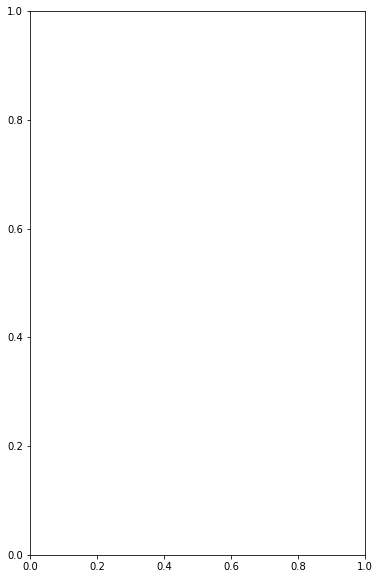

KeyError: 'mean'

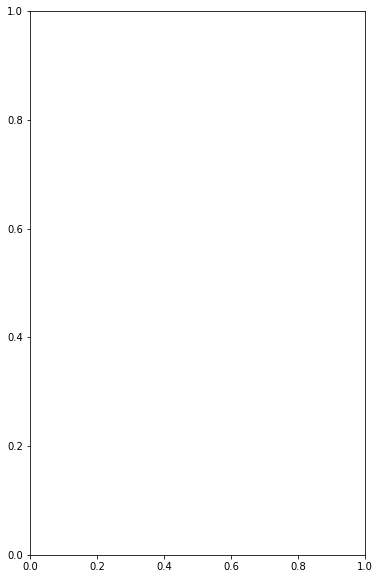

In [5]:
values_to_plot_merged

Treatment                                 CS_10D   Cs_5DIZ
Velocity                          mean -0.573361  0.573361
                                  sem   0.195029  0.173178
Angular velocity                  mean -0.415650  0.415650
                                  sem   0.237086  0.168035
Minimum wing angle                mean  0.287009 -0.287009
                                  sem   0.273943  0.137534
Maximum wing angle                mean  0.303546 -0.303546
                                  sem   0.272046  0.137563
Mean Wing length                  mean  0.621945 -0.621945
                                  sem   0.151158  0.197650
Distance to wall                  mean  0.399448 -0.399448
                                  sem   0.255170  0.143959
Distance from center              mean -0.399448  0.399448
                                  sem   0.255170  0.143959
Distance to closest Fly           mean -0.127397  0.127397
                                  sem   0.268491  0.169811
Mean distance to all flies        mean -0.226782  0.226782
                                  sem   0.259371  0.173044
Mean degree (Weight: Count)       mean -0.901979  0.901979
                                  sem   0.093845  0.090477
Mean degree (Weight: Duration)    mean -0.810002  0.810002
                                  sem   0.075172  0.167085
Degree Heterogeneity (Count)      mean  0.344080 -0.344080
                                  sem   0.214161  0.210486
Degree Heterogeneity (Duration)   mean  0.488968 -0.488968
                                  sem   0.240049  0.140857
Degree Assortativity (Count)      mean  0.249693 -0.249693
                                  sem   0.254955  0.176257
Degree Assortativity (Duration)   mean  0.404154 -0.404154
                                  sem   0.231596  0.178329
Clustering Coefficient (Count)    mean -0.705232  0.705232
                                  sem   0.180916  0.132469
Clustering Coefficient (Duration) mean -0.789445  0.789445
                                  sem   0.149960  0.120587
Betweenness Centrality (Count)    mean  0.756703 -0.756703
                                  sem   0.167458  0.119648
Betweenness Centrality (Duration) mean  0.769360 -0.769360
                                  sem   0.186615  0.074159
Closeness Centrality (Count)      mean  0.805108 -0.805108
                                  sem   0.183835  0.024590
Closeness Centrality (Duration)   mean  0.829782 -0.829782
                                  sem   0.172452  0.020355

In [ ]:
import os
import pandas as pd
from src.utils import fileio
import os 
import pandas as pd
import numpy as np
from src.utils import fileio
import matplotlib.pyplot as plt

TREATMENT = "LDA_5DIZ"

cols_to_take = [
    'Degree heterogeneity (count)',
    'Degree heterogeneity (total duration (seconds))',
    'Degree aassortativity (count)',
    'Degree aassortativity (total duration (seconds))',
    'Average clustering coefficient weight=count',
    'Average clustering coefficient weight=duration(seconds)',
    'Average betweenness centrality weight=count',
    'Average betweenness centrality weight=duration(seconds)',
    'Average closseness centrality weight=count',
    'Average closseness centrality weight=duration(seconds)'
]

shuffled_path = os.path.join("/srv/milky/drosophila-datasets/drosophila-isolation/data/results/shuffled_nets_global_measures", TREATMENT)
treatment_shuffled = fileio.load_multiple_folders(shuffled_path)

num_groups = len(treatment_shuffled)
fig, axes = plt.subplots(num_groups, len(cols_to_take), figsize=(len(cols_to_take) * 6, num_groups * 6))
if num_groups == 1:
    axes = [axes]
if len(cols_to_take) == 1:
    axes = [ax for ax in axes]

for group_idx, (group_name, group_path) in enumerate(treatment_shuffled.items()):
    group_shuffled_graphs = fileio.load_files_from_folder(group_path)
    df = pd.read_csv(group_shuffled_graphs[f'{group_name}.csv'], index_col=0)
    real_path = f'/srv/milky/drosophila-datasets/drosophila-isolation/data/results/global_measures/{TREATMENT}.csv'
    df_real = pd.read_csv(real_path, index_col=0)
    df_real = df_real.loc[group_name,]  # This filters df_real for the specific group
    df = df[cols_to_take]

    for col_idx, column in enumerate(df.columns):
        ax = axes[group_idx, col_idx]  # Get the corresponding axis for the subplot
        ax.hist(df[column], bins=30, alpha=0.6, color='blue', label=f"{column} - Shuffled Data", range=(0, 1))
        real_value = df_real[column]  # Directly use the real value since it's already a scalar
        ax.axvline(real_value, color='red', linestyle='dashed', linewidth=2, label=f"{column} - Real Value")
        mean_value = df[column].mean()
        ax.axvline(mean_value, color='yellow', linestyle='solid', linewidth=2, label=f"{column} - Mean")
        ax.set_xlim(-0.1, 1.1)
        ax.set_title(f"{group_name} - {column}")
        ax.set_xlabel(f"{column}")
        ax.set_ylabel("Frequency")
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
df_real

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import os 
import pandas as pd
import numpy as np
from src.utils import fileio
import sys

TREATMENTS = ['CS_10D', 'CsCh', 'Cs_5DIZ', 'LDA_5DIZ', 'OCT_5DIZ', 'LDA_OCT_5DIZ']
path = "/srv/milky/drosophila-datasets/drosophila-isolation/data/results/local_measures"

all_res = []
for t in TREATMENTS:
    measures = fileio.load_files_from_folder(os.path.join(path, t), '.csv')
    
    for group_name, group_path in measures.items():
        df = pd.read_csv(group_path)
        df = df.rename(columns={'Unnamed: 0': 'Fly'})
        df['Group'] = group_name.replace('.csv', '')
        df['Treatment'] = t
        
        all_res.append(df)

total = pd.concat(all_res)
c = ['Fly', 'Group', 'Treatment',
     'In-Strength distribution, w=count',
     'Out-Strength distribution, w=count',
    #  'In-Strength distribution, w=duration',
    #  'Out-Strength distribution, w=duration',
     'Weighted Degree (count)', 
    #  'Weighted Degree (duration(seconds))',
     'Betweenness centrality w=count',
    #  'Betweenness centrality w=duration(seconds)',
     'Clustering coefficient w=count',
    #  'Clustering coefficient w=duration(seconds)',
    ]
df = total[c]
df.set_index(['Treatment', 'Group', 'Fly'], inplace=True)

filtered_df = df.loc[df.index.get_level_values('Treatment').isin(['CS_10D', 'Cs_5DIZ', 'CsCh'])]
df_reset = filtered_df.reset_index()
# df_reset['Color'] = df_reset['Treatment'].map({'CS_10D': 'blue', 'CS_5DIZ': 'red'})

measures = df_reset.columns.difference(['Treatment', 'Group', 'Fly'])
for measure in measures:
    plt.figure(figsize=(9, 5))
    sns.scatterplot(
        data=df_reset,
        x="Group",
        y=measure,
        hue="Treatment",
        s=50,
        alpha=0.6,
        markers=True,
        style="Treatment",
    )
    plt.xticks([]) 
    plt.title(f'{measure}')
    plt.xlabel('Group')
    plt.ylabel('Measure Value')
    plt.grid()
    plt.xticks(rotation=90)
    
plt.show()

# path = "/srv/milky/drosophila-datasets/drosophila-isolation/data/processed/1_0_find_interactions/Cs_5DIZ"
# group = "Cs_5DIZ_24_11_2023_10_22_A2.csv"

# df = pd.read_csv(os.path.join(path, group), index_col=0)
# selected_rows = df[(df['node_1'] == 'fly6') | (df['node_2'] == 'fly6')]